In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') 
import os

In [2]:
train=pd.read_csv("../input/train-fold/train_fold.csv")
test=pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
sample_submission=pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv")

In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=a55e82c55f1cb9e3a9b55f118fe271d8965a623a1676e8449481dda8f0c5e2b8
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


In [4]:
from PIL import Image
class ClassificationLoader:
    def __init__(self, image_paths, targets, resize, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        targets = self.targets[item]

        image = np.array(image)
        if self.augmentations:
            image = self.augmentations(image=image)["image"]
        return {
            "img":torch.tensor(image, dtype=torch.float),
            "tar":torch.tensor(targets, dtype=torch.long)
        }

In [5]:
from torch.utils.data.dataset import Dataset
class CutMix(Dataset):
    def __init__(self, dataset, num_class, num_mix=1, beta=1., prob=0.5):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob
        
    def rand_bbox(self, size, lam):
        if len(size) == 4:
            W = size[2]
            H = size[3]
        elif len(size) == 3:
            W = size[1]
            H = size[2]
        else:
            raise Exception

        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

    def onehot(self,size, target):
        vec = torch.zeros(size, dtype=torch.float32)
        vec[target] = 1.
        return vec
    
    def __getitem__(self, index):
        data=self.dataset[index]
        img, lb = data["img"],data["tar"]
        lb_onehot = self.onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            r = np.random.rand(1)
            if self.beta <= 0 or r > self.prob:
                continue

            # generate mixed sample
            lam = np.random.beta(self.beta, self.beta)
            rand_index = random.choice(range(len(self)))

            data=self.dataset[rand_index]
            img2, lb2 = data["img"],data["tar"]
            lb2_onehot = self.onehot(self.num_class, lb2)

            bbx1, bby1, bbx2, bby2 = self.rand_bbox(img.size(), lam)
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)

        return {
            "img":torch.tensor(img, dtype=torch.float),
            "tar":torch.tensor(lb_onehot, dtype=torch.long)
        }

    def __len__(self):
        return len(self.dataset)

In [6]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# EfficientNet-b4
class EffiNet(nn.Module):
    def __init__(self,classes):
        super(EffiNet, self).__init__()
        self.classes=classes
        self.base_model = EfficientNet.from_pretrained("efficientnet-b4")
        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out

# Resnet50
import torchvision
class Resnet50(nn.Module):
    def __init__(self,classes):
        super(Resnet50, self).__init__()
        self.classes=classes
        self.base_model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out       
# densenet
import torchvision
class Densenet(nn.Module):
    def __init__(self,classes):
        super(Densenet, self).__init__()
        self.classes=classes
        self.base_model = torchvision.models.densenet201(pretrained=True)
        num_ftrs = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out    
# EfficientNet-b7
class EffiNet7(nn.Module):
    def __init__(self,classes):
        super(EffiNet7, self).__init__()
        self.classes=classes
        self.base_model = EfficientNet.from_pretrained("efficientnet-b7")
        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out     

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
SIZE=224
import random

class Utils:
    def __init__():
        pass
    def get_aug(mode="train"):
        if mode=="Nor":
            aug=A.Compose([
                ToTensor(),
            ])
        elif mode =="train":
            aug=A.Compose([
                A.Flip(),
                A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),
                # Pixels
                A.OneOf([
                    A.IAAEmboss(p=1.0),
                    A.IAASharpen(p=1.0),
                    A.Blur(p=1.0),
                ], p=0.5),
                # Affine
                A.OneOf([
                    A.ElasticTransform(p=1.0),
                    A.IAAPiecewiseAffine(p=1.0)
                ], p=0.5),

                A.Normalize(p=1.0),
                ToTensor(),
            ])
        else:
            aug=A.Compose([
                A.Normalize(p=1.0),
                ToTensor(),
            ])

        return aug 
    def get_model(model_name, classes):
        if model_name=="effinet": return EffiNet(classes=classes)
        if model_name=="resnet": return Resnet50(classes=classes)    
        if model_name=="densenet": return Densenet(classes=classes)    
        if model_name=="effinet7": return EffiNet7(classes=classes)   

In [8]:
# ## My Image cumix test
# import matplotlib.pyplot as plt

# train_df=train[train.kfold!=0].reset_index(drop=True)
# imgs=train_df.image_id.values.tolist()
# path="../input/plant-images-224-224-png/"
# train_imgs=[path+file+".png" for file in imgs]
# train_aug=Utils.get_aug("Nor")
# train_tar=train_df.category.values
# train_dataset=ClassificationLoader(
#     image_paths=train_imgs,targets=train_tar,resize=None,augmentations=train_aug
# )
# CutMix_train_dataloader = CutMix(train_dataset, 
#                           num_class=4, 
#                           beta=1.0, 
#                           prob=0.999, 
#                           num_mix=1)
# train_loader=torch.utils.data.DataLoader(
#     CutMix_train_dataloader,batch_size=128,num_workers=4,shuffle=True)

# for data in train_loader:
#     img=data["img"]
#     tar=data["tar"]
#     for i in range(10):
#         img2=img[i].permute(1,2,0)
#         tar2=tar[i].numpy()
#         #print(tar2)        
#         plt.imshow(np.uint(img2*256))
#         plt.figure()
#         cnt+=1
#     break


In [9]:
#clcarwin / focal_loss_pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
#         if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
#         if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
# My Focal Loss
class FocalLoss2(nn.Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss2, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def fl_onehot(self,index,classes,tar):
        y_onehot = torch.FloatTensor(index, classes).to("cuda")
        y_onehot.zero_()
        y_onehot.scatter_(1, tar, 1)
        return (y_onehot)        
    def forward(self, inputs, targets):
        y = self.fl_onehot(inputs.size()[0],inputs.size()[1],targets.view(-1,1))
        logit = F.softmax(inputs, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.mean()      
# My Focal Loss
class FocalLoss3(nn.Module):# for cutmix
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss3, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def forward(self, inputs, targets):
        logit = F.softmax(inputs, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * targets * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.mean()  
import torch.nn.functional as F
class DenseCrossEntropy(nn.Module):
    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()    

In [10]:
class History:
    def __init__(self,model_name):
        self.train_info=dict()
        self.valid_info=dict()
        self.best_idx=np.zeros(10)
        self.model_name=model_name
    def initial_info(self,fold):
        key=f"F{fold}_Acc"
        self.train_info[key]=[]
        key=f"F{fold}_loss"
        self.train_info[key]=[]    
        key=f"F{fold}_Acc"
        self.valid_info[key]=[]
        key=f"F{fold}_loss"
        self.valid_info[key]=[]     
        key=f"F{fold}_labels"
        self.valid_info[key]=[]     
        key=f"F{fold}_preds"
        self.valid_info[key]=[]
    def add_train_info(self,fold, train_acc,train_loss,valid_acc,valid_loss,valid_labels,valid_preds):
        key=f"F{fold}_Acc"
        self.train_info[key].append(train_acc)
        key=f"F{fold}_loss"
        self.train_info[key].append(train_loss)
        key=f"F{fold}_Acc"
        self.valid_info[key].append(valid_acc)
        key=f"F{fold}_loss"
        self.valid_info[key].append(valid_loss) 
        key=f"F{fold}_labels"
        self.valid_info[key].append(valid_labels) 
        key=f"F{fold}_preds"
        self.valid_info[key].append(valid_preds) 
    def get_best_info(fold):
        ids=self.best_idx[fold]
        return self.valid_info[f"F{fold}_acc"][ids],\
    self.valid_info[f"F{fold}_labels"][ids],\
    self.valid_info[f"F{fold}_preds"][ids]

In [11]:
## Engine
from sklearn.metrics import accuracy_score
class Engine:
    def __init__(self,model,optimizer,device,classes,weights=None):
        self.model=model
        self.optimizer=optimizer
        self.device=device
        self.classes=classes
        self.weights=weights
        
        class_weights = torch.FloatTensor(weights).cuda()
        self.criterion=nn.CrossEntropyLoss(class_weights)
#         self.criterion=DenseCrossEntropy()
#         self.criterion=FocalLoss2()
#         self.criterion=FocalLoss3()
    
    def loss_fn(self,targets,outputs):
        return self.criterion(outputs,targets)
        
    def get_accuracy(self,labels,preds):
        total=labels.shape[0]
        preds=preds.argmax(1).reshape(-1,1)
        return np.uint8(labels==preds).sum()/total
    
    def train(self,data_loader):
        preds_for_acc = []
        labels_for_acc = []
        self.model.train()
        final_loss=0
        for data in data_loader:
            self.optimizer.zero_grad()
            inputs=data["img"].to(self.device)
            targets=data["tar"].to(self.device)
            outputs=self.model(inputs)
            loss=self.loss_fn(targets,outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            ## accuracy
            labels = targets.cpu().numpy().reshape(-1,1)
            preds = outputs.cpu().detach().numpy()
            if len(labels_for_acc)==0:
                labels_for_acc = labels
                preds_for_acc = preds
            else:
                labels_for_acc=np.vstack((labels_for_acc,labels))
                preds_for_acc=np.vstack((preds_for_acc,preds))
        accuracy = self.get_accuracy(labels_for_acc,preds_for_acc)
        return final_loss/len(data_loader),accuracy
    
    def validate(self,data_loader):
        preds_for_acc = []
        labels_for_acc = []
        self.model.eval()
        final_loss=0
        for data in data_loader:
            inputs=data["img"].to(self.device)
            targets=data["tar"].to(self.device)
            with torch.no_grad():
                outputs=self.model(inputs)
                loss=self.loss_fn(targets,outputs)
                final_loss += loss.item()
            ## accuracy
            labels = targets.cpu().numpy().reshape(-1,1)
            preds = outputs.cpu().detach().numpy()
            if len(labels_for_acc)==0:
                labels_for_acc = labels
                preds_for_acc = preds
            else:
                labels_for_acc=np.vstack((labels_for_acc,labels))
                preds_for_acc=np.vstack((preds_for_acc,preds))
        accuracy = self.get_accuracy(labels_for_acc,preds_for_acc)
        return final_loss/len(data_loader),accuracy,labels_for_acc,preds_for_acc
    
    def predict(self,data_loader):
        self.model.eval()
        final_predictions = []
        for data in data_loader:
            inputs=data["img"].to(self.device)
            predictions = self.model(inputs)
            predictions = predictions.cpu()
            final_predictions.append(predictions.detach().numpy())
        return final_predictions

In [45]:
bs_train=16
bs_valid=12

import datetime
def loop_train(fold, model_name,weights):
    history.initial_info(fold)
    train_df=train[train.kfold!=fold].reset_index(drop=True)#[0:65]
    valid_df=train[train.kfold==fold].reset_index(drop=True)#[0:64]
    train_df["result"]=train_df["category"].apply(lambda x : x>0).astype(np.int)
    valid_df["result"]=valid_df["category"].apply(lambda x : x>0).astype(np.int)

    imgs=train_df.image_id.values.tolist()
    path="../input/plant-images-224-224-png/"
    train_imgs=[path+file+".png" for file in imgs]
    train_aug=Utils.get_aug("train")
    train_tar=train_df.result.values
    train_dataset=ClassificationLoader(
        image_paths=train_imgs,targets=train_tar,resize=None,augmentations=train_aug
    )
#     CutMix_train_dataloader = CutMix(train_dataset, 
#                           num_class=4, 
#                           beta=1.0, 
#                           prob=0.999, 
#                           num_mix=1)
    CutMix_train_dataloader=train_dataset
    train_loader=torch.utils.data.DataLoader(
        CutMix_train_dataloader,batch_size=bs_train,num_workers=4,shuffle=True
    )
    
    imgs=valid_df.image_id.values.tolist()
    path="../input/plant-images-224-224-png/"
    valid_imgs=[path+file+".png" for file in imgs]
    valid_aug=Utils.get_aug("valid")
    valid_tar=valid_df.result.values
    valid_dataset=ClassificationLoader(
        image_paths=valid_imgs,targets=valid_tar,resize=None,augmentations=valid_aug
    )
#     CutMix_valid_dataloader = CutMix(valid_dataset, 
#                           num_class=4, 
#                           beta=1.0, 
#                           prob=0, 
#                           num_mix=1)
    CutMix_valid_dataloader=valid_dataset
    valid_loader=torch.utils.data.DataLoader(
        CutMix_valid_dataloader,batch_size=bs_valid,num_workers=4,shuffle=False
    )
    
    # Model,Optimizer, scheduler, engine
    model=Utils.get_model(model_name,classes=2)
    
    device="cuda" if torch.cuda.is_available() else "cpu"
    model=model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,patience=3,threshold=1e-5,mode="min",verbose=True
    )

    engine=Engine(model,optimizer,device,classes=2,weights=weights)
    best_loss=np.inf
    early_stopping=3#3
    early_stopping_cnt=0
    EPOCH=300
    for epoch in range(EPOCH):
        train_loss,train_acc=engine.train(train_loader)
        valid_loss,valid_acc,valid_labels,valid_preds=engine.validate(valid_loader)
        scheduler.step(valid_loss)
        
        # Add train Info
        history.add_train_info(fold,train_acc,train_loss,valid_acc,valid_loss,valid_labels,valid_preds)
        tm=datetime.datetime.now().strftime("%H:%M:%S")
        print(f"{tm}, fold={fold}, epoch={epoch}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}, valid_acc={valid_acc:.4f}")    
        
        if valid_loss<best_loss :
            best_loss=valid_loss
            torch.save(model.state_dict(),f"model_fold_{fold}.bin")
            early_stopping_cnt=0
            history.best_idx[fold]=epoch
        else:
            early_stopping_cnt+=1
        if early_stopping_cnt>early_stopping:
            break

    print(f"fold={fold}, best val loss={best_loss}")

In [61]:
def loop_train_process(model_name):
#     loop_train(fold=0,model_name=model_name,weights=[1,1])
#     loop_train(fold=0,model_name=model_name,weights=[2,1])
     loop_train(fold=0,model_name=model_name,weights=[4,1])
#     loop_train(fold=0,model_name=model_name,weights=[8,1])
#     loop_train(fold=0,model_name=model_name,weights=[16,1])
#     loop_train(fold=0,model_name=model_name,weight=[32,1])
    
    
    
#     loop_train(fold=1,model_name=model_name)
#     loop_train(fold=2,model_name=model_name)
#     loop_train(fold=3,model_name=model_name)
#     loop_train(fold=4,model_name=model_name)


In [62]:
history=History(model_name="effinet")
loop_train_process(model_name="effinet")

Loaded pretrained weights for efficientnet-b4
14:31:36, fold=0, epoch=0, train_loss=0.5266, valid_loss=0.2354, valid_acc=0.8849
14:32:28, fold=0, epoch=1, train_loss=0.1957, valid_loss=0.1247, valid_acc=0.9425
14:33:20, fold=0, epoch=2, train_loss=0.1392, valid_loss=0.0913, valid_acc=0.9479
14:34:13, fold=0, epoch=3, train_loss=0.1149, valid_loss=0.0735, valid_acc=0.9699
14:35:01, fold=0, epoch=4, train_loss=0.0860, valid_loss=0.0645, valid_acc=0.9726
14:35:52, fold=0, epoch=5, train_loss=0.0721, valid_loss=0.0593, valid_acc=0.9671
14:36:44, fold=0, epoch=6, train_loss=0.0618, valid_loss=0.0797, valid_acc=0.9616
14:37:38, fold=0, epoch=7, train_loss=0.0479, valid_loss=0.0819, valid_acc=0.9616
14:38:29, fold=0, epoch=8, train_loss=0.0482, valid_loss=0.0501, valid_acc=0.9836
14:39:19, fold=0, epoch=9, train_loss=0.0410, valid_loss=0.0572, valid_acc=0.9808
14:40:06, fold=0, epoch=10, train_loss=0.0512, valid_loss=0.0818, valid_acc=0.9671
14:40:53, fold=0, epoch=11, train_loss=0.0397, vali

In [63]:
roc_auc=[]
for epoch in range(15):
    best_idx=np.int(epoch)
    labels=history.valid_info["F0_labels"][best_idx]
    preds=history.valid_info["F0_preds"][best_idx]
    preds=preds.argmax(1)
    d1=pd.DataFrame({"preds":preds,"labels":labels.squeeze(-1)})

    d1["result"]=(d1.preds==d1.labels)
    d1.result=d1.result.astype(np.int)
    d2=d1[d1.labels==0]
    d3=d1[d1.labels==1]
    accuracy=d1.result.sum()/d1.shape[0]
    sensitivity=d3.result.sum()/d3.shape[0]
    speciality=d2.result.sum()/d2.shape[0]
    sample=[accuracy,sensitivity,1-speciality]
    if len(roc_auc)==0:
        roc_auc=sample
    else:
        roc_auc=np.vstack((roc_auc,sample))

        df1=pd.DataFrame(roc_auc,columns=["accuracy","sensitivity","speciality"])

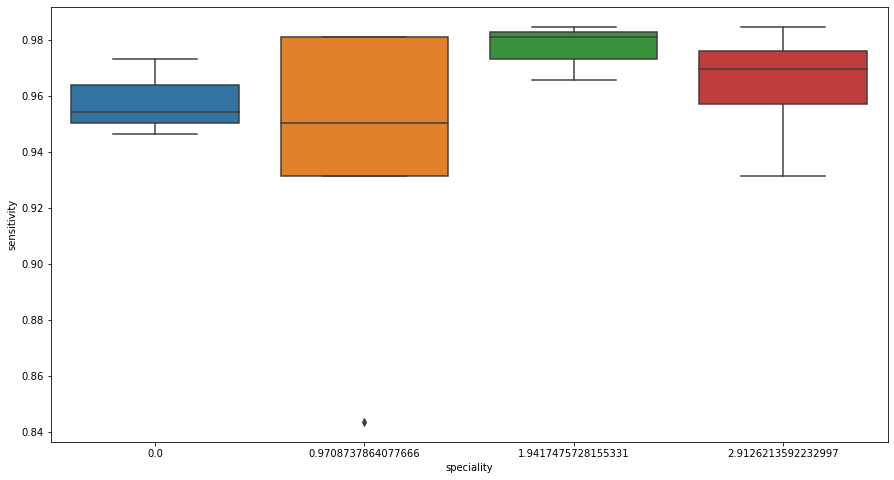

In [64]:
# [4,1]
f,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x=df1.speciality*100,y=df1.sensitivity)

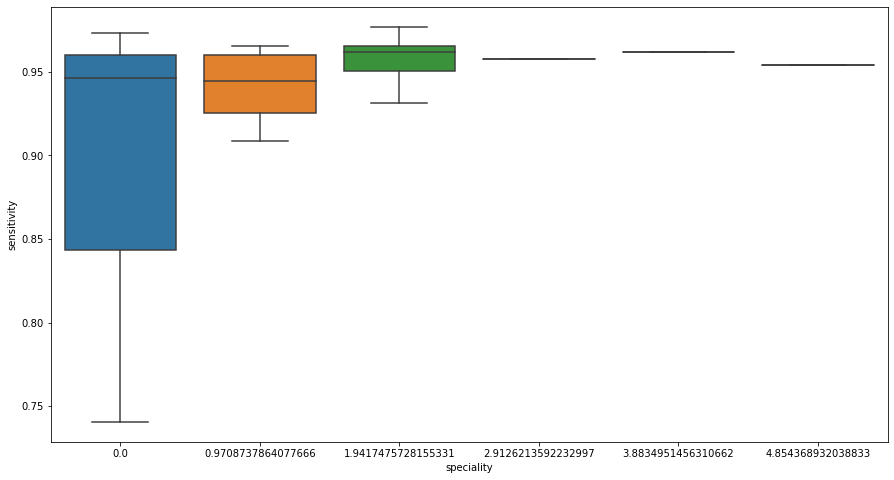

In [59]:
# [16,1]
f,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x=df1.speciality*100,y=df1.sensitivity)

In [60]:
df1

,accuracy,sensitivity,speciality
0,0.813699,0.740458,0.000000
1,0.931507,0.908397,0.009709
2,0.953425,0.954198,0.048544
3,0.961644,0.961832,0.038835
4,0.958904,0.950382,0.019417
5,0.961644,0.958015,0.029126
6,0.967123,0.961832,0.019417
7,0.945205,0.931298,0.019417
8,0.969863,0.965649,0.019417
9,0.978082,0.977099,0.019417


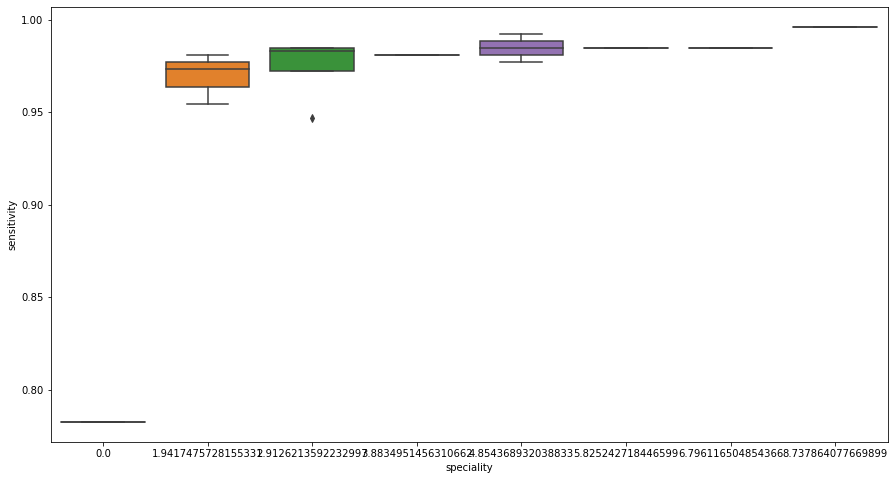

In [52]:
# [1,1]
f,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x=df1.speciality*100,y=df1.sensitivity)

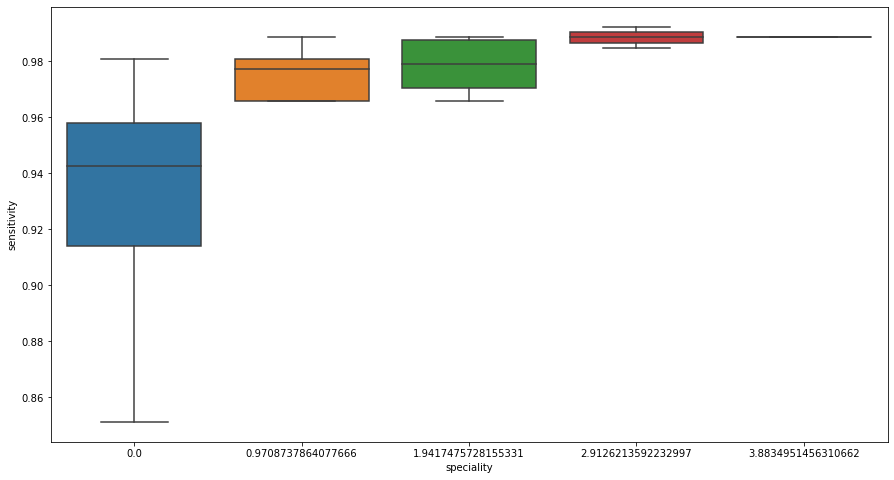

In [44]:
# [2,1]
f,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x=df1.speciality*100,y=df1.sensitivity)


In [30]:
df1

,accuracy,sensitivity,speciality
0,0.893151,0.851145,0.000000
1,0.969863,0.965649,0.019417
2,0.972603,0.965649,0.009709
3,0.983562,0.984733,0.019417
4,0.953425,0.935115,0.000000
5,0.986301,0.992366,0.029126
6,0.983562,0.980916,0.009709
7,0.980822,0.988550,0.038835
8,0.975342,0.973282,0.019417
9,0.986301,0.988550,0.019417
